In [177]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch import nn, optim

In [201]:
image_1d_size = 128
image_2d_size = image_1d_size**2
image_3d_size = image_2d_size*3

In [202]:
#Define pathway
data_dir = 'Cat_Dog_data'

#Define transforms for training and test sets to convert to desirable tensors for processing
train_transform = transforms.Compose([transforms.RandomRotation(20),
                                      transforms.RandomResizedCrop(image_1d_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5,0.5)])

test_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                 transforms.CenterCrop(image_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(0.5, 0.5)])

#Create training and testing datasets and transform them with defined transforms above
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)

test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transform) 

#Turn training and testing datasets into generators that can be accessed by an iterator or loop
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['cat', 'dog']
tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 49152])
torch.Size([32, 49152])


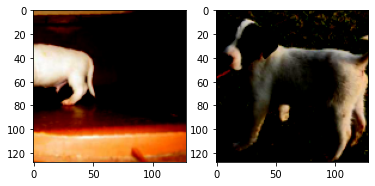

In [204]:
#Create training and testing image iterators to cycle through
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

#Print class and label information to understand data structure
print(train_data.classes)
print(train_labels)
print(test_labels)
print(train_images.shape)
print(test_images.shape)
print(train_images.view(train_images.shape[0], -1).shape)
print(test_images.view(test_images.shape[0], -1).shape)

#Plot an example image from test set and training set
plt.subplot(1, 2, 1)
plt.imshow(train_images[0].numpy().transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(test_images[0].numpy().transpose((1, 2, 0)))

In [205]:
#Create a Classifier class, inheriting from nn.Module and incorporating Relu, Dropout and log_softmax
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_3d_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, len(train_data.classes))
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [206]:
#Create our model from our prepared classifier and define the loss criterion and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#Initialize testing loss history
training_loss_history, testing_loss_history = [], []

In [192]:
epochs = 1

for e in range(epochs):
    epoch_train_loss = 0 # initialize total training loss for this epoch
    for images, labels in train_loader: # cycle through training data
        optimizer.zero_grad() # clear gradient history
        log_out = model(images) # run image through model to get logarithmic probability
        loss = criterion(log_out, labels) # calculate loss (error) for this image batch based on criterion
        
        loss.backward() # backpropogate gradients through model based on error
        optimizer.step() # update weights in model based on calculated gradient information
        epoch_train_loss += loss.item() # add training loss to total train loss this epoch, convert to value with .item()
    
    else:
        epoch_test_loss = 0 # initialize total testing loss for this epoch
        test_count_correct = 0 # initialize total correct predictions on test set
        with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
            for images, labels in test_loader: # cycle through testing data to observe performance
                log_out = model(images, labels) # obtain the logarithmic probability from the model
                loss = criterion(log_out) # calculate loss (error) for this image batch based on criterion
                epoch_test_lost += loss.item() # add testing loss to total test loss this epoch, convert to value with .item()
                
                out = torch.exp(log_out) # obtain probability from the logarithmic probability calculated by the model
                highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greatest calculated probability
                equals = chosen_class.view(labels.shape) == labels # determine how many correct matches were made in this batch
                test_count_correct += equals.sum()  # add the count of correct matches this batch to the total running this epoch
            
            ave_training_loss = epoch_train_loss / len(train_loader) # determine average loss per batch of training images
            ave_testing_loss = epoch_test_loss / len(test_loader) # determine average loss per batch of testing images
            training_loss_history.append(ave_training_loss) # append ave training loss to history of training losses
            training_loss_history.append(ave_training_loss) # append ave testing loss to history of testing losses
        
        model.train()
        print('Epoch: {}/{}.. '.format(e+1, epochs),
            'Training Loss: {:.3f}.. '.format(training_loss),
            'Test Loss: {:.3f}.. '.format(testing_loss),
            'Test Accuracy: {:.3f}'.format(testing_correct_count / len(testloader.dataset)))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x49152 and 16384x256)

130